In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast



2024-04-02 07:12:14.106068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 07:12:14.106120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 07:12:14.107408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 07:12:14.115326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 07:12:15.219173: W tensorflow/compiler/tf2

In [4]:
# Define the directories for the models
knowledge_model_dir = "../data/knowledge/preprocess/d2v/model_d2v_combined.model"
standard_model_dir = "../data/sample_q_and_a/preprocess/d2v/model_d2v_qa.model"
df = pd.read_csv("../data/sample_q_and_a/rules_facts.csv")
data = pd.read_csv("../data/knowledge/all_types.csv")

In [5]:
df.head()







,Context,Knowledge,Response
0,Hi,greeting,Hello there. Tell me how are you feeling today?
1,Hi,greeting,Hi there. What brings you here today?
2,Hi,greeting,Hi there. How are you feeling today?
3,Hi,greeting,Great to see you. How do you feel currently?
4,Hi,greeting,Hello there. Glad to see you're back. What's g...


In [737]:
df2 = df.copy()
df2.head()

,Context,Knowledge,Response
0,Hi,greeting,Hello there. Tell me how are you feeling today?
1,Hi,greeting,Hi there. What brings you here today?
2,Hi,greeting,Hi there. How are you feeling today?
3,Hi,greeting,Great to see you. How do you feel currently?
4,Hi,greeting,Hello there. Glad to see you're back. What's g...


In [738]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 649 rows and 3 columns


In [739]:
#display information about the dataset
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Context    645 non-null    object
 1   Knowledge  649 non-null    object
 2   Response   649 non-null    object
dtypes: object(3)
memory usage: 15.3+ KB
None


In [740]:
#display number of classes
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Knowledge', "Chatbot")

The Chatbot dataset has 80 classes


In [741]:
#check for null values
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")
#check for missing values
def check_missing(df, ds_name='df'):
    print(f"Missing Values in each col in the {ds_name} dataset:\n")
    print(df.isna().sum())
check_missing(df, "Chatbot")


Null Values in each col in the Chatbot dataset:

Context      4
Knowledge    0
Response     0
dtype: int64
Missing Values in each col in the Chatbot dataset:

Context      4
Knowledge    0
Response     0
dtype: int64


In [742]:
#drop null values
def drop_null(df, col):
    df.dropna(subset=[col], inplace=True)
    print(f"Null Values in {col} dropped")
drop_null(df, 'Context')

Null Values in Context dropped


In [743]:
#check for null values
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Context      0
Knowledge    0
Response     0
dtype: int64


In [744]:
# visualize the frequency of the classes
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

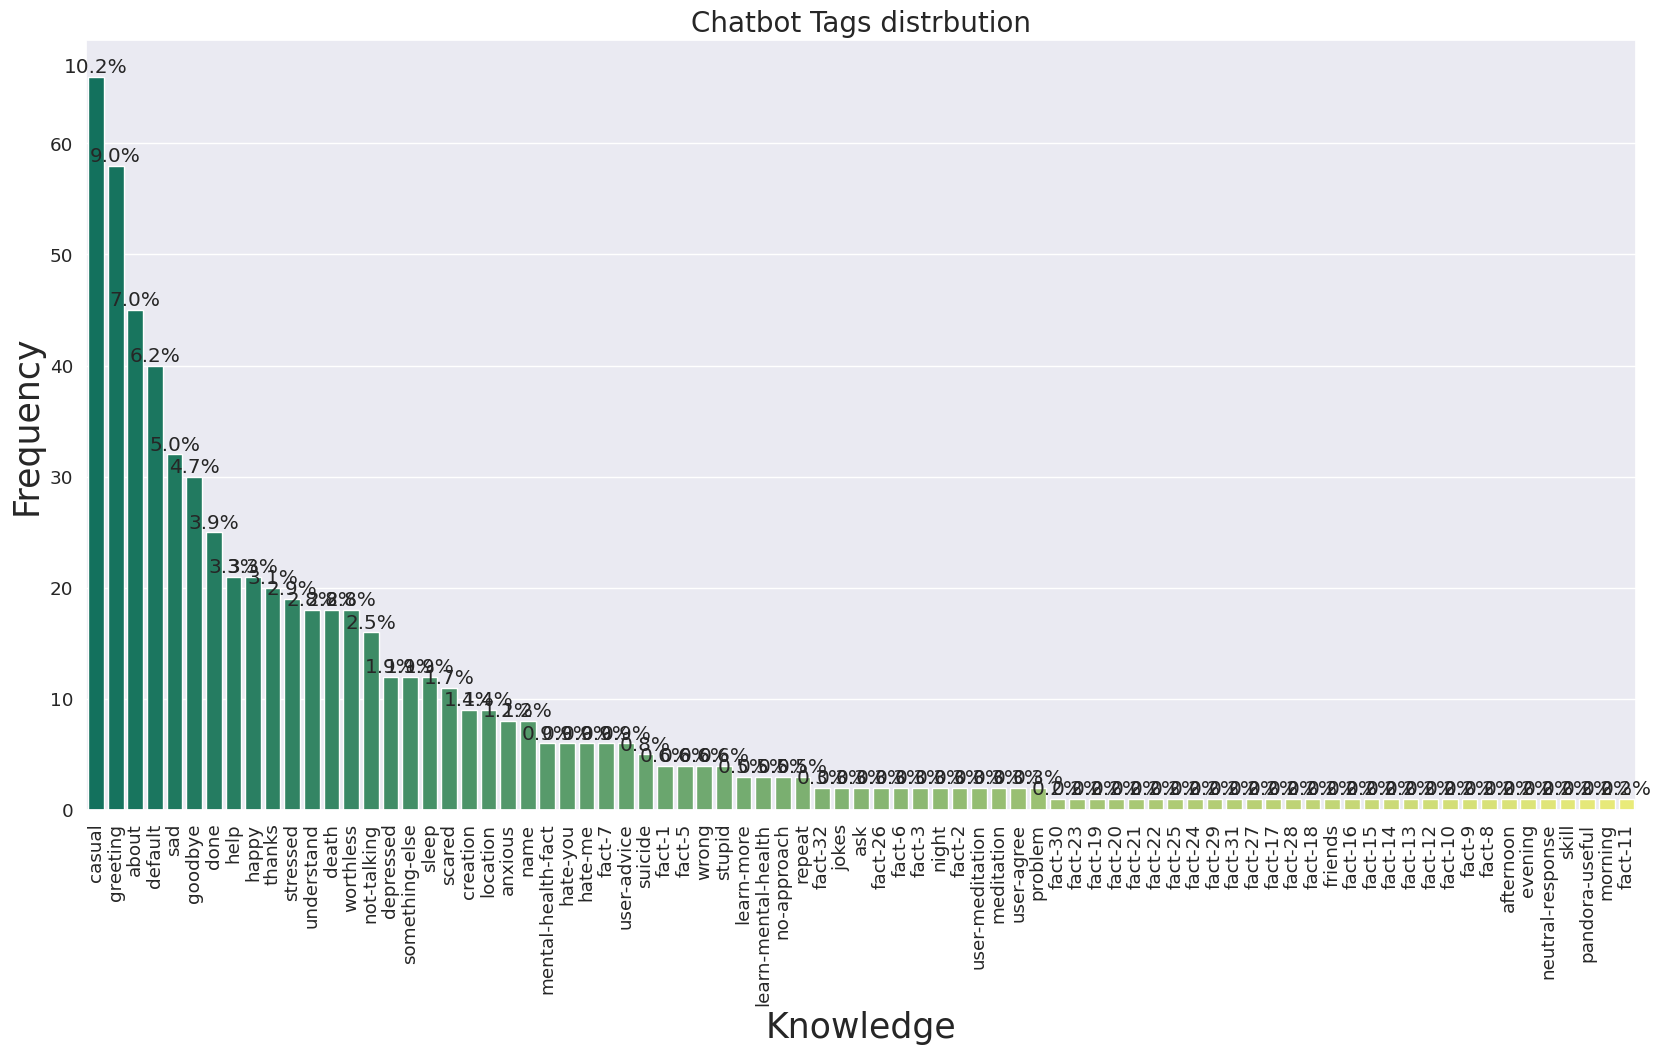

In [745]:
sns.set(font_scale = 1.2)
order = df['Knowledge'].value_counts().index
count_plot(df['Knowledge'], df, "Chatbot Tags distrbution", "Knowledge", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [746]:
#preprocess the context column
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Context'] = df['Context'].apply(preprocess_pattern)

In [747]:
df.head()


,Context,Knowledge,Response
0,hi,greeting,Hello there. Tell me how are you feeling today?
1,hi,greeting,Hi there. What brings you here today?
2,hi,greeting,Hi there. How are you feeling today?
3,hi,greeting,Great to see you. How do you feel currently?
4,hi,greeting,Hello there. Glad to see you're back. What's g...


In [748]:
print(df['Context'].isnull().sum())


0


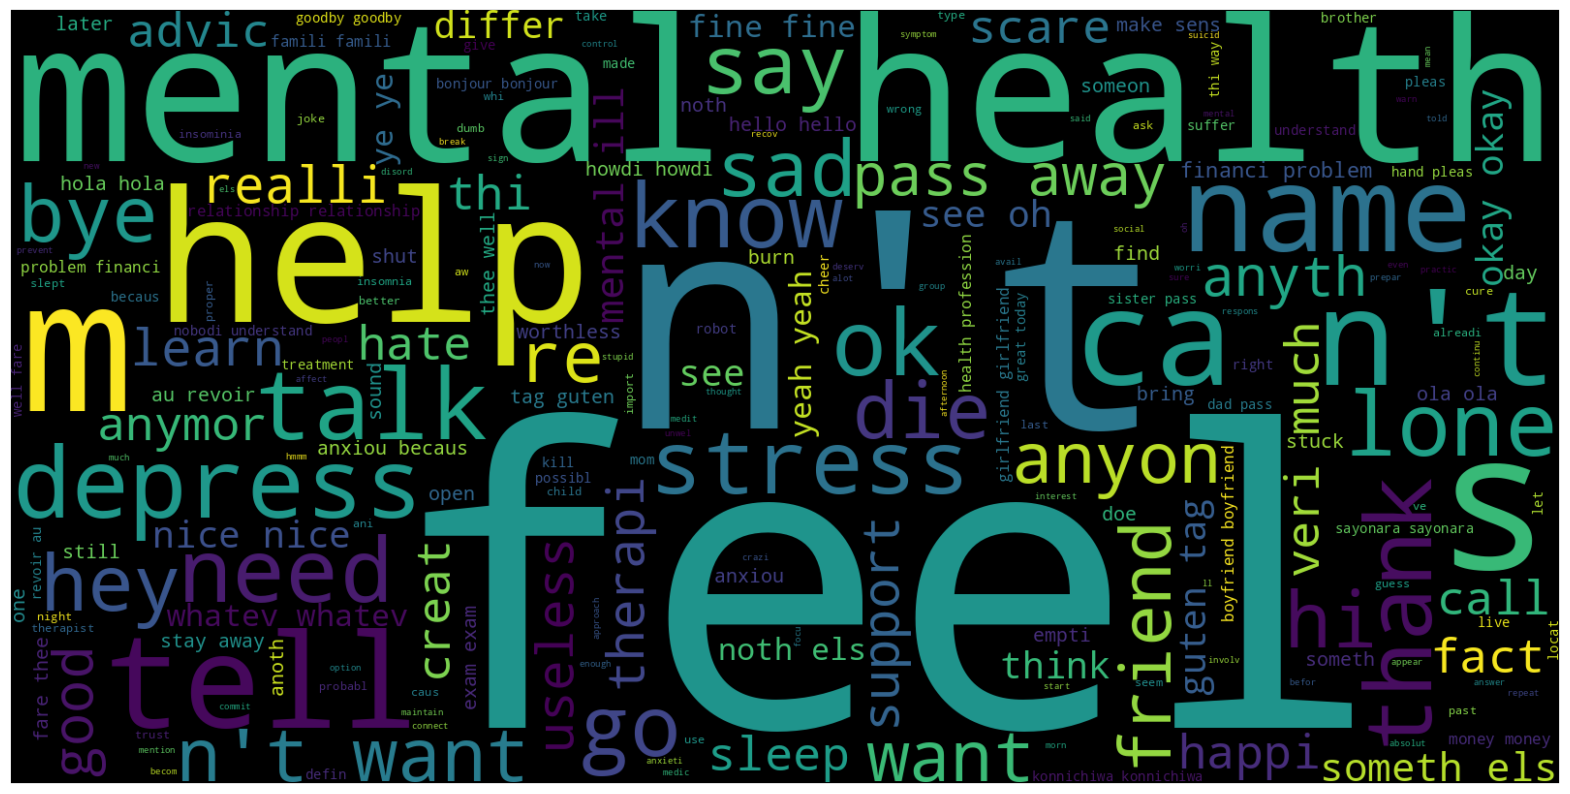

In [749]:
#display world cloud
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Context']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

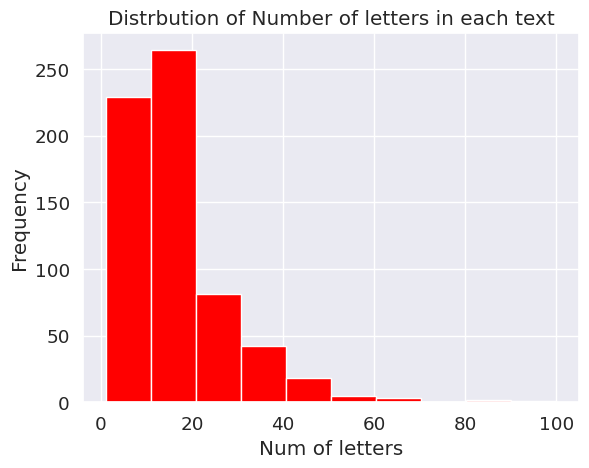

In [750]:
#distribution of number of letters in each word
letters_len=df['Context'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

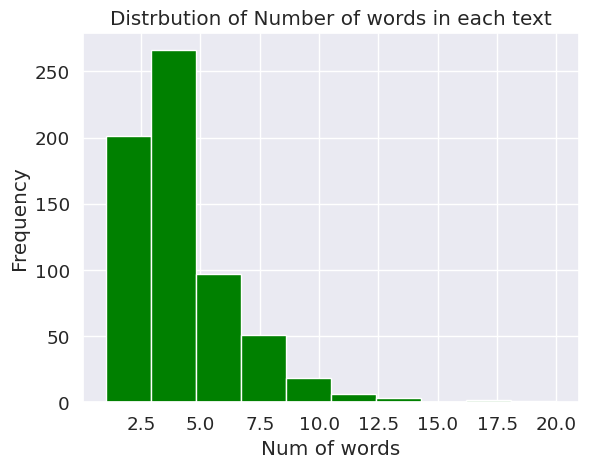

In [751]:
#distribution of number of words in each text
words_len=df['Context'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

In [752]:
#visualize top words
def get_corpus(df, col):
    words = []
    for pattern in df[col]:
        for word in pattern.split():
            words.append(word)
    return words
corpus = get_corpus(df, 'Context')
print(corpus[:10])

['hi', 'hi', 'hi', 'hi', 'hi', 'hey', 'hey', 'hey', 'hey', 'hey']


In [753]:
print(f"dataset contains {len(corpus)} words")


dataset contains 2404 words


In [754]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'i': 241,
 'you': 106,
 'what': 59,
 "n't": 55,
 'do': 53,
 'me': 52,
 'feel': 52,
 'am': 46,
 'to': 46,
 'about': 44}

In [755]:
#data preparation
df.head()

,Context,Knowledge,Response
0,hi,greeting,Hello there. Tell me how are you feeling today?
1,hi,greeting,Hi there. What brings you here today?
2,hi,greeting,Hi there. How are you feeling today?
3,hi,greeting,Great to see you. How do you feel currently?
4,hi,greeting,Hello there. Glad to see you're back. What's g...


In [756]:
#creating labels
labels = df['Knowledge'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'morning',
 'afternoon',
 'evening',
 'night',
 'goodbye',
 'thanks',
 'neutral-response',
 'about',
 'skill',
 'creation',
 'name',
 'help',
 'sad',
 'stressed',
 'worthless',
 'depressed',
 'happy',
 'casual',
 'anxious',
 'not-talking',
 'sleep',
 'scared',
 'death',
 'understand',
 'done',
 'suicide',
 'hate-you',
 'hate-me',
 'default',
 'jokes',
 'repeat',
 'wrong',
 'stupid',
 'location',
 'something-else',
 'friends',
 'ask',
 'problem',
 'no-approach',
 'learn-more',
 'user-agree',
 'meditation',
 'user-meditation',
 'pandora-useful',
 'user-advice',
 'learn-mental-health',
 'mental-health-fact',
 'fact-1',
 'fact-2',
 'fact-3',
 'fact-5',
 'fact-6',
 'fact-7',
 'fact-8',
 'fact-9',
 'fact-10',
 'fact-11',
 'fact-12',
 'fact-13',
 'fact-14',
 'fact-15',
 'fact-16',
 'fact-17',
 'fact-18',
 'fact-19',
 'fact-20',
 'fact-21',
 'fact-22',
 'fact-23',
 'fact-24',
 'fact-25',
 'fact-26',
 'fact-27',
 'fact-28',
 'fact-29',
 'fact-30',
 'fact-31',
 'fact-32']

In [757]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [758]:
id2label, label2id



({0: 'greeting',
  1: 'morning',
  2: 'afternoon',
  3: 'evening',
  4: 'night',
  5: 'goodbye',
  6: 'thanks',
  7: 'neutral-response',
  8: 'about',
  9: 'skill',
  10: 'creation',
  11: 'name',
  12: 'help',
  13: 'sad',
  14: 'stressed',
  15: 'worthless',
  16: 'depressed',
  17: 'happy',
  18: 'casual',
  19: 'anxious',
  20: 'not-talking',
  21: 'sleep',
  22: 'scared',
  23: 'death',
  24: 'understand',
  25: 'done',
  26: 'suicide',
  27: 'hate-you',
  28: 'hate-me',
  29: 'default',
  30: 'jokes',
  31: 'repeat',
  32: 'wrong',
  33: 'stupid',
  34: 'location',
  35: 'something-else',
  36: 'friends',
  37: 'ask',
  38: 'problem',
  39: 'no-approach',
  40: 'learn-more',
  41: 'user-agree',
  42: 'meditation',
  43: 'user-meditation',
  44: 'pandora-useful',
  45: 'user-advice',
  46: 'learn-mental-health',
  47: 'mental-health-fact',
  48: 'fact-1',
  49: 'fact-2',
  50: 'fact-3',
  51: 'fact-5',
  52: 'fact-6',
  53: 'fact-7',
  54: 'fact-8',
  55: 'fact-9',
  56: 'fact-10'

In [759]:
df['labels'] = df['Knowledge'].map(lambda x: label2id[x.strip()])
df.head()

,Context,Knowledge,Response,labels
0,hi,greeting,Hello there. Tell me how are you feeling today?,0
1,hi,greeting,Hi there. What brings you here today?,0
2,hi,greeting,Hi there. How are you feeling today?,0
3,hi,greeting,Great to see you. How do you feel currently?,0
4,hi,greeting,Hello there. Glad to see you're back. What's g...,0


In [760]:
#split the data in to test and training
X = df['Context']
y = df['labels']
print(X.shape)
print(y.shape)

(645,)
(645,)


In [761]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [762]:
#load pretrained BERT model and tokenizer
from transformers import BertTokenizer
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [763]:
#tranform the data into numerical format
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [764]:
X = [str(x) for x in X]
full_data = tokenizer(X, truncation=True, padding=True)

In [765]:
#build data loader
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [766]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [767]:
fullDataLoader = DataLoader(full_data, y_test)

In [768]:
#define evaluation metrics
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [769]:
from transformers import TrainingArguments
#define training arguments
training_args = TrainingArguments(
    output_dir='../data/sample_q_and_a/output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

In [770]:
#train the model
from transformers import Trainer, TrainingArguments
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics = compute_metrics
)


In [771]:
#drop the column thats giving error and go to next column and execute trainer.train()
trainer.train()


KeyError: 246